In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [34]:
# Data
games_season = pd.read_csv('games_season.csv')
games_tourney = pd.read_csv('games_tourney.csv')

print('Regular season data')
print(games_season.head())

print('Tournament data')
print(games_tourney.head())

# Count the number of unique teams
n_teams = np.unique(games_season['team_1']).shape[0]

Season games
   season  team_1  team_2  home  score_diff  score_1  score_2  won
0    1985    3745    6664     0          17       81       64    1
1    1985     126    7493     1           7       77       70    1
2    1985     288    3593     1           7       63       56    1
3    1985    1846    9881     1          16       70       54    1
4    1985    2675   10298     1          12       86       74    1
Tournament games
   season  team_1  team_2  home  seed_diff  score_diff  score_1  score_2  won
0    1985     288      73     0         -3          -9       41       50    0
1    1985    5929      73     0          4           6       61       55    1
2    1985    9884      73     0          5          -4       59       63    0
3    1985      73     288     0          3           9       50       41    1
4    1985    3920     410     0          1          -9       54       63    0


In [3]:
# Embedding layer
from tensorflow.keras.layers import Embedding

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, name='Team-Strength')

2021-11-28 14:38:44.520716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 14:38:44.520778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Model
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

2021-11-28 14:38:45.850066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-28 14:38:45.850117: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-28 14:38:45.850144: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-28 14:38:45.850445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Shared layers

# Defining two inputs
from tensorflow.keras.layers import Input

# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

# Create a subtract layer to merge team strengths
from tensorflow.keras.layers import Subtract

score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
from tensorflow.keras.models import Model

model = Model([team_in_1, team_in_2], score_diff)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [22]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Get the score_diff column from the regular season data
target = games_season['score_diff']

# Fit the model
history = model.fit([input_1, input_2], target, epochs=2**9, batch_size=2**11, validation_split=.1, verbose=0)

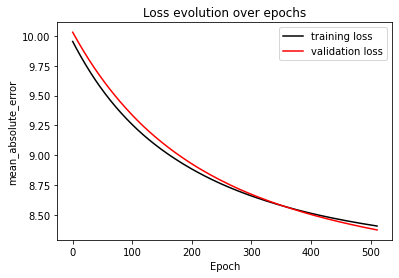

In [32]:
plt.plot(history.history['loss'], label='training loss', color='black')
plt.plot(history.history['val_loss'], label='validation loss', color='red')
plt.title('Loss evolution over epochs')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend()
plt.show()

In [35]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Get score_diff from the tournament data
target = games_tourney['score_diff']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], target)

133/133 [==============================] - 0s 749us/step - loss: 8.9593


8.959250450134277

In [37]:
model.layers[2]